In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from exp.nb_05b import *
torch.set_num_threads(2)

## ConvNet

In [3]:
x_train, y_train, x_valid, y_valid = get_data()

In [4]:
def normalize_to(train, valid):
    m, s = train.mean(), train.std()
    return normalize(train, m, s), normalize(valid, m, s)

In [5]:
x_train, x_valid = normalize_to(x_train, x_valid)
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)

In [6]:
x_train.mean(), x_train.std()

(tensor(0.0001), tensor(1.))

In [7]:
nh, bs = 50, 512
c = y_train.max().item() + 1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [8]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x): return self.func(x)

In [9]:
def flatten(x): return x.view(x.shape[0], -1)
def mnist_resize(x): return x.view(-1, 1, 28, 28)

In [10]:
def get_cnn_model(data):
    return nn.Sequential(
        Lambda(mnist_resize),
        nn.Conv2d(1, 8, 5, padding=2, stride=2), nn.ReLU(), # 14
        nn.Conv2d(8, 16, 3, padding=1, stride=2), nn.ReLU(), # 7
        nn.Conv2d(16, 32, 3, padding=1, stride=2), nn.ReLU(), # 4
        nn.Conv2d(32, 32, 3, padding=1, stride=2), nn.ReLU(), # 2
        nn.AdaptiveAvgPool2d(1),
        Lambda(flatten),
        nn.Linear(32, data.c)
    )

In [11]:
model = get_cnn_model(data)

In [12]:
cbfs = [Recorder, partial(AvgStatsCallback, accuracy)]

In [13]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [14]:
%time run.fit(1, learn)

train: [1.821174375, tensor(0.3575)]
valid: [0.754544580078125, tensor(0.7628)]
CPU times: user 53.6 s, sys: 46.4 s, total: 1min 40s
Wall time: 14.2 s


## Cuda

In [15]:
device = torch.device('cuda', 0)

In [16]:
class CudaCallback(Callback):
    def __init__(self, device): self.device = device
    def begin_fit(self): self.model.to(self.device)
    def begin_batch(self):
        self.run.xb, self.run.yb = self.xb.to(self.device), self.yb.to(self.device)

In [18]:
torch.cuda.set_device(device)

In [19]:
class CudaCallback(Callback):
    def begin_fit(self): self.model.cuda()
    def begin_batch(self): self.run.xb, self.run.yb = self.xb.cuda(), self.yb.cuda()

In [20]:
cbfs.append(CudaCallback)

In [21]:
model = get_cnn_model(data)

In [22]:
opt = optim.SGD(model.parameters(), lr=.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [23]:
%time run.fit(3, learn)

train: [1.55442796875, tensor(0.4705, device='cuda:0')]
valid: [0.750873583984375, tensor(0.7743, device='cuda:0')]
train: [0.3068309375, tensor(0.9075, device='cuda:0')]
valid: [0.18656893310546874, tensor(0.9480, device='cuda:0')]
train: [0.1742909765625, tensor(0.9484, device='cuda:0')]
valid: [0.11848753662109375, tensor(0.9667, device='cuda:0')]
CPU times: user 4.14 s, sys: 1.57 s, total: 5.71 s
Wall time: 26.1 s


## Refactor model

In [24]:
def conv2d(ni, nf, ks=3, stride=2):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), nn.ReLU())

In [26]:
class BatchTransformXCallback(Callback):
    _order = 2
    def __init__(self, tfm): self.tfm = tfm
    def begin_batch(self): self.run.xb = self.tfm(self.xb)
        
def view_tfm(*size):
    def _inner(x): return x.view(*((-1,) + size))
    return _inner

In [28]:
mnist_view = view_tfm(1, 28, 28)
cbfs.append(partial(BatchTransformXCallback, mnist_view))

In [29]:
nfs = [8, 16, 32, 32]

In [30]:
def get_cnn_layers(data, nfs):
    nfs = [1] + nfs
    return [
        conv2d(nfs[i], nfs[i+1], 5 if i==0 else 3)
        for i in range(len(nfs)-1)
    ] + [nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def get_cnn_model(data, nfs): return nn.Sequential(*get_cnn_layers(data, nfs))

In [33]:
def get_runner(model, data, lr=0.6, cbs=None, opt_func=None, loss_func=F.cross_entropy):
    if opt_func is None: opt_func = optim.SGD
    opt = opt_func(model.parameters(), lr)
    learn = Learner(model, opt, loss_func, data)
    return learn, Runner(cb_funcs=listify(cbs))

In [34]:
model = get_cnn_model(data, nfs)
learn, run = get_runner(model, data, lr=.4, cbs=cbfs)

In [35]:
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): AdaptiveAvgPool2d(output_size=1)
  (5): Lambda()
  (6): Linear(in_features=32, out_features=10, bias=True)
)

In [36]:
run.fit(3, learn)

train: [1.7273078125, tensor(0.4337, device='cuda:0')]
valid: [0.512340771484375, tensor(0.8482, device='cuda:0')]
train: [0.3231652734375, tensor(0.9046, device='cuda:0')]
valid: [0.1919356201171875, tensor(0.9405, device='cuda:0')]
train: [0.1795070703125, tensor(0.9454, device='cuda:0')]
valid: [0.13192974853515624, tensor(0.9604, device='cuda:0')]


## Hooks

### Manual insertion

In [37]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds = [[] for _ in layers]
        
    def __call__(self, x):
        for i, l in enumerate(self.layers):
            x = l(x)
            if self.training:
                self.act_means[i].append(x.mean())
                self.act_stds[i].append(x.std())
        return x
    
    def __iter__(self): return iter(self.layers)

In [38]:
model = SequentialModel(*get_cnn_layers(data, nfs))
learn, run = get_runner(model, data, lr=.9, cbs=cbfs)

In [39]:
run.fit(2, learn)

train: [2.1904496875, tensor(0.1985, device='cuda:0')]
valid: [1.21867138671875, tensor(0.6207, device='cuda:0')]
train: [0.763203359375, tensor(0.7593, device='cuda:0')]
valid: [0.2447831787109375, tensor(0.9256, device='cuda:0')]


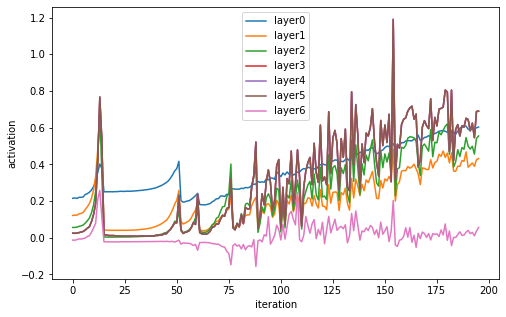

In [50]:
fig, ax = plt.subplots(figsize=(8, 5))
for l, m in enumerate(model.act_means): 
    ax.plot(m, label=f"layer{l}")
    ax.legend()
    ax.set_xlabel('iteration')
    ax.set_ylabel('activation');

# fin